## Introduction

Imagine that you are a medical researcher and have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient is correspond to one of 5 drugs.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and Sodium to Potassium ratio. The target variable is the drug that each patient uses.

It is a sample of multiclass classifier, and you can build a decision tree, and then use it to prescribe a drug to a new patient.

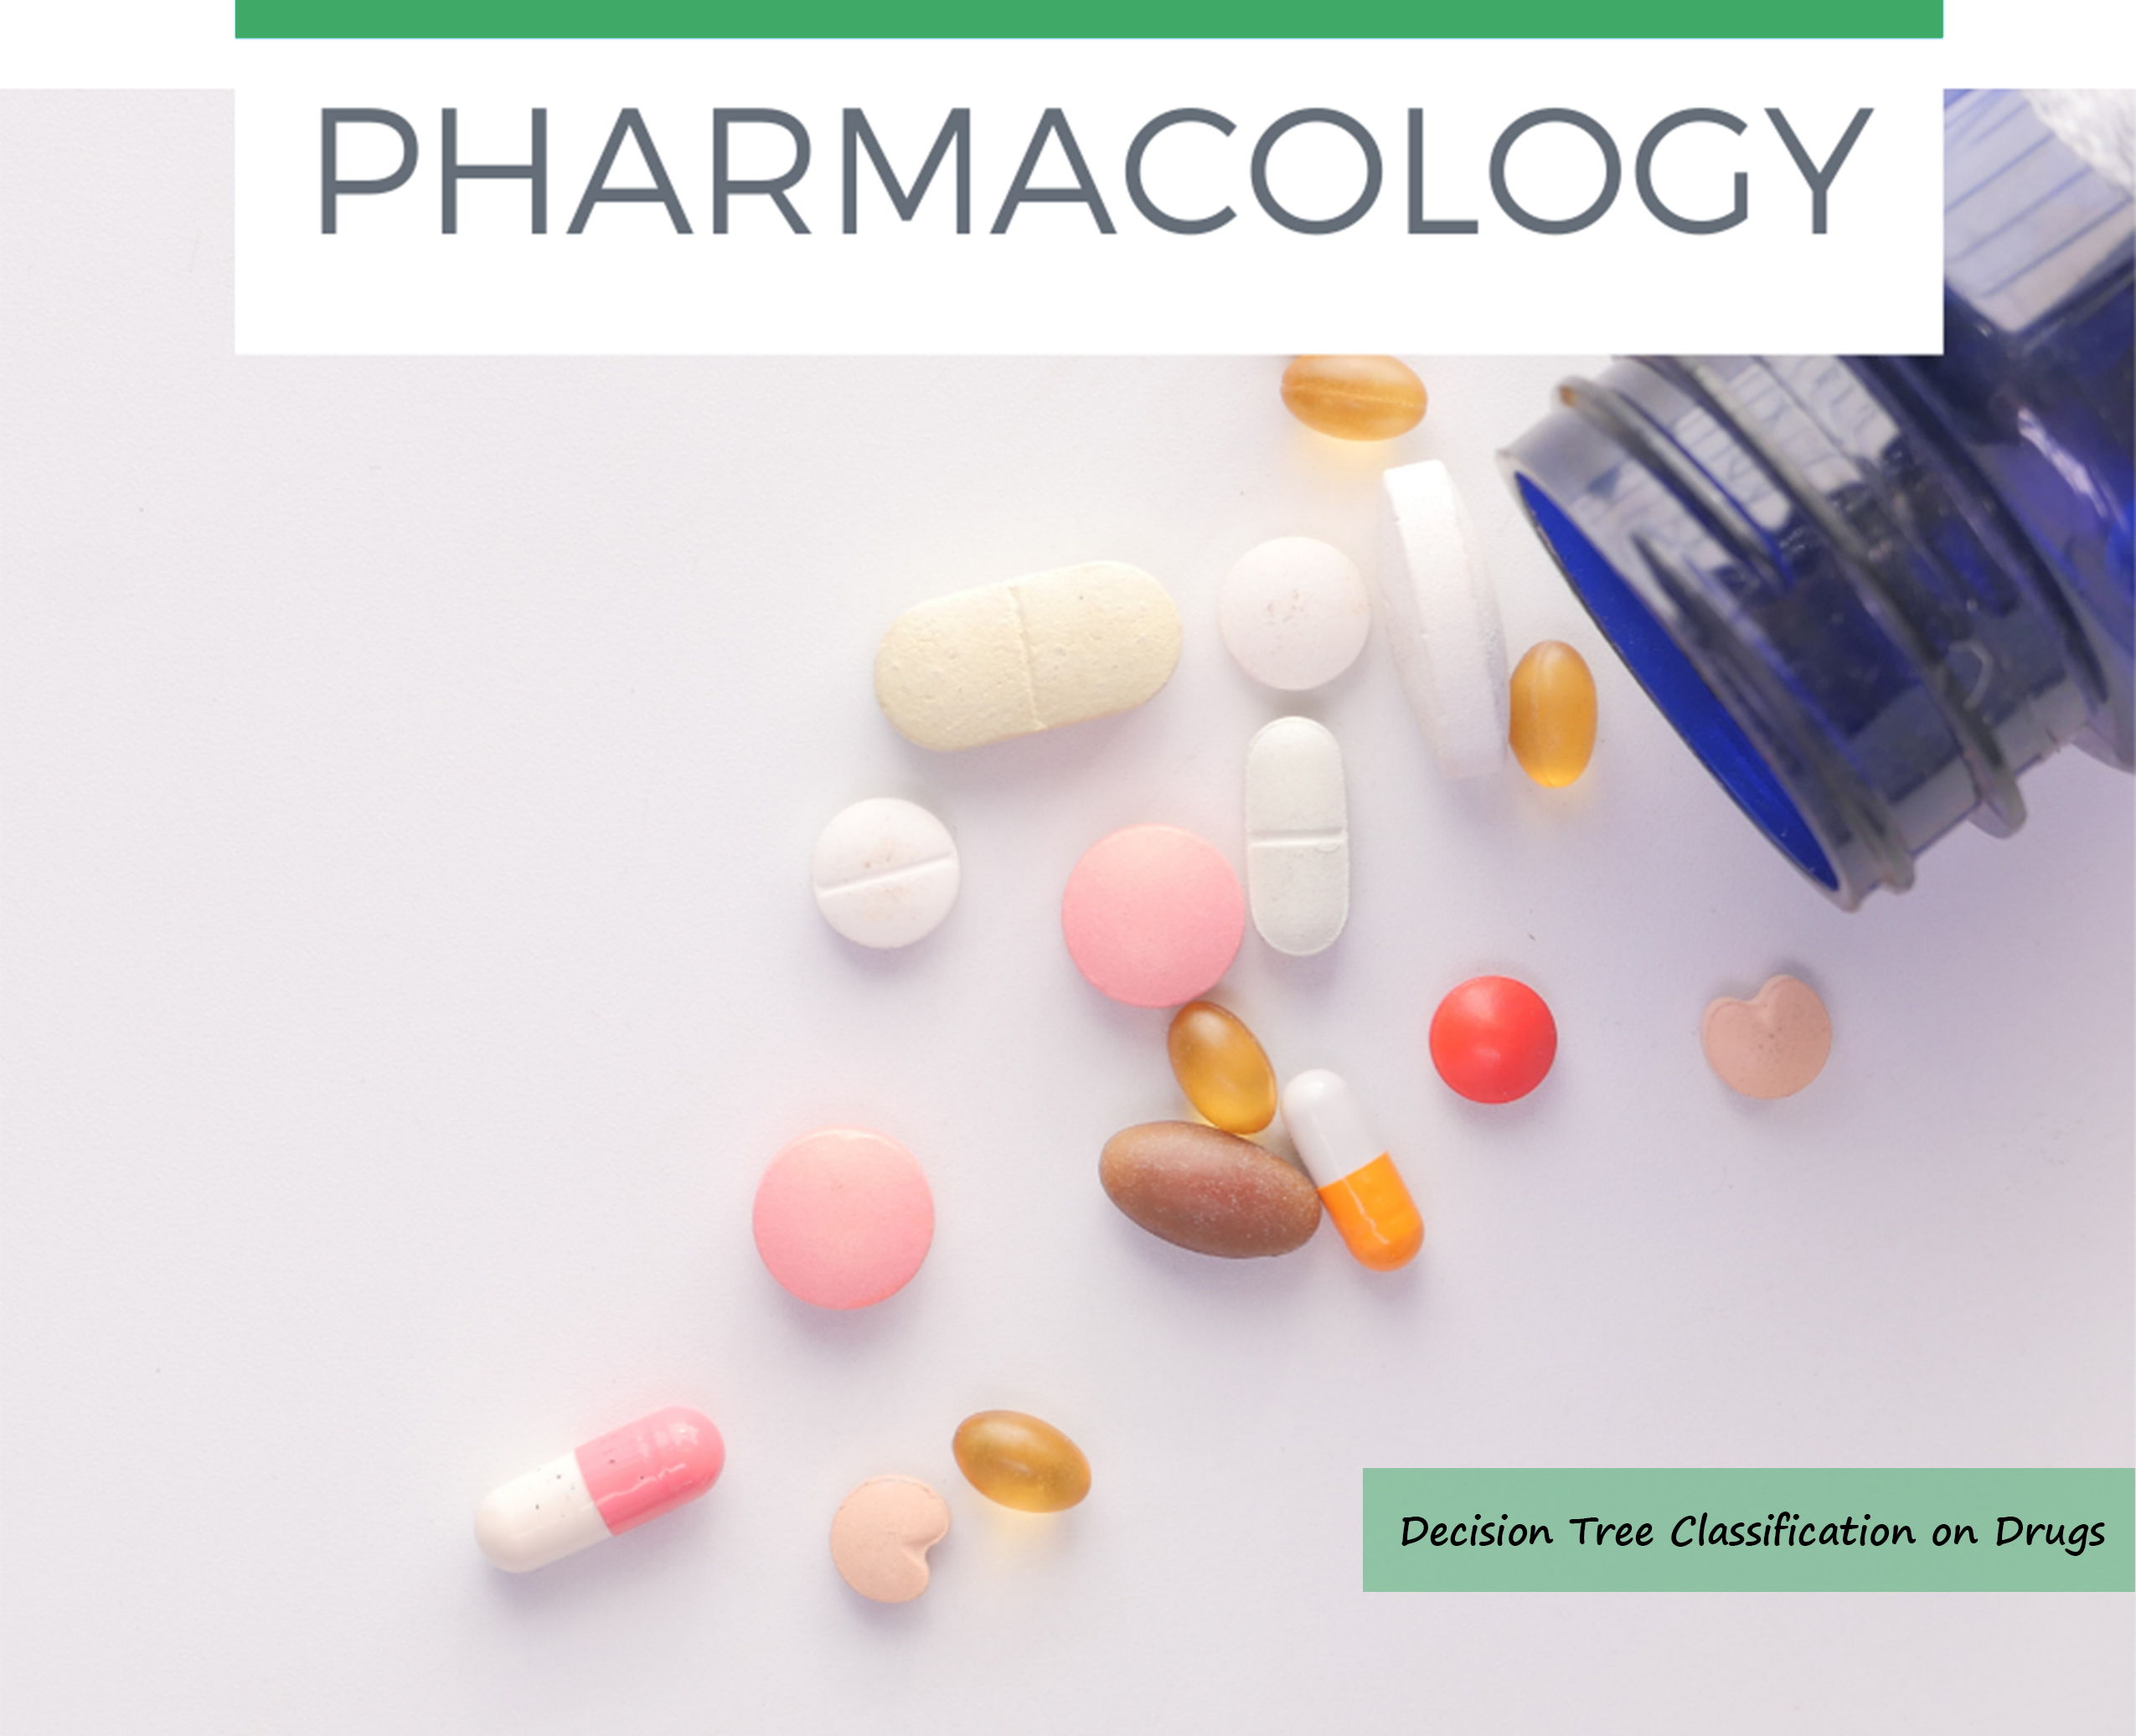

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

import pydotplus
import graphviz
import warnings
warnings.filterwarnings('ignore')
import sys

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()  # Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
def pd_read_csv_drive(id, drive, dtype=None):
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('Filename.csv')
  return(pd.read_csv('Filename.csv',dtype=dtype))

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### READ THE DATASET


[Kaggle Dataset link](https://www.kaggle.com/datasets/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees)


In [ ]:
df=pd_read_csv_drive('1bChf3UU_NO_vy_Yc-CTeAl10I_P2pYku',drive)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [ ]:
# df = pd.read_csv('drug200.csv')
# df.head()
#Sodium to Potassium ratio

In [ ]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Percentage of classes in the dataset

df['Drug'].value_counts()*100/df.shape[0]

drugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: Drug, dtype: float64

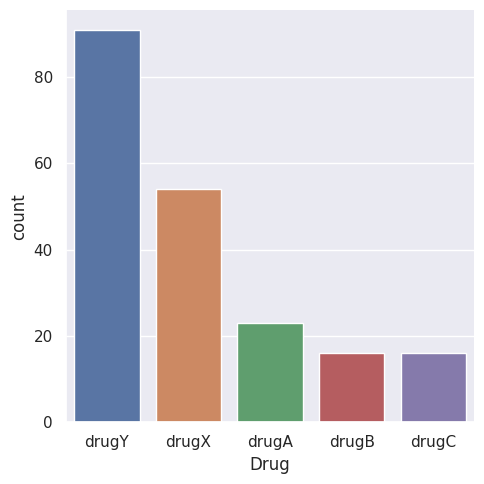

In [ ]:
sns.catplot(data = df, x = 'Drug', kind = 'count', order = ['drugY',
                                                            'drugX',
                                                            'drugA',
                                                            'drugB', 'drugC'])

In [ ]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


<Axes: xlabel='Age', ylabel='Density'>

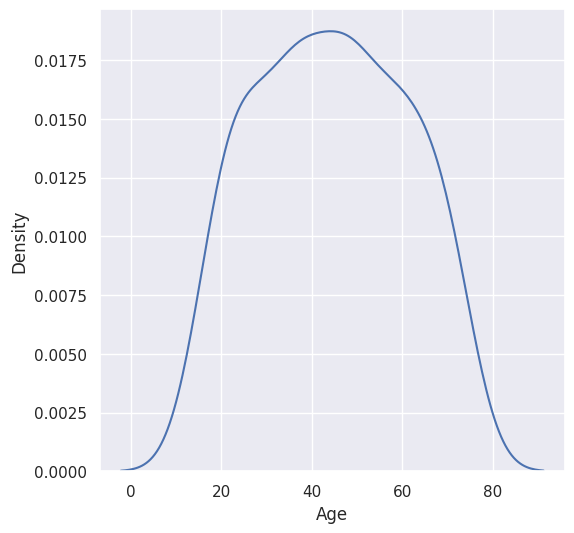

In [ ]:
sns.kdeplot(data = df, x = 'Age')

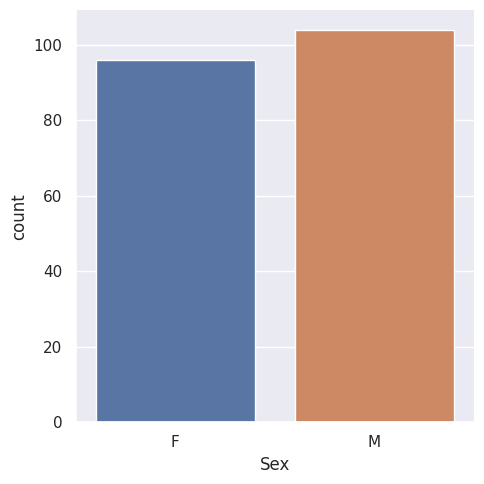

In [ ]:
sns.catplot(data = df, x = 'Sex', kind = 'count')

In [ ]:
# Mapping categorical to numerical entities
# <Encoding>

df['Sex'] = df['Sex'].map({'M':1,
                          'F':0})

df['BP'] = df['BP'].map({'HIGH':2,
                         'NORMAL':1,
                         'LOW':0})

df['Cholesterol'] = df['Cholesterol'].map({'HIGH':1,
                                           'NORMAL':0})


In [ ]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.355,drugY
1,47,1,0,1,13.093,drugC
2,47,1,0,1,10.114,drugC
3,28,0,1,1,7.798,drugX
4,61,0,0,1,18.043,drugY


## Train Test Split

In [ ]:
X=df.drop(['Drug'],axis=1)
y=df[['Drug']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)

## CALCULATING GINI, ENTROPY, AND GAIN

This is a 5 class problem.\

The number of classes (Drug A, B, C, X, and Y) can be found using value counts in python, and calculting their probabilities by grouping the data in association with the target.


In [ ]:
ind_prob = [df['Drug'].value_counts()/df.shape[0]]
ind_prob, df.shape

([drugY    0.455
  drugX    0.270
  drugA    0.115
  drugC    0.080
  drugB    0.080
  Name: Drug, dtype: float64],
 (200, 6))

## GINI - ENTROPY

In [ ]:
# GINI ENTROPY CALC
import math

c =[1, 1, 2] # c = [1/4, 1/4, 2/4]

def calc_gini_entropy(prob):
    c = prob
    x = [elem / sum(c) for elem in c]
    # print(x)
    entropy = []
    gini = []

    for i in x:
        log_2 = math.log(i, 2)
        #print(log_2)
        gini.append(i**2)
        entropy.append(-(i*log_2))
        #print(f'i: {i}, log_2: {log_2}')

    # print(f'Entropy: {entropy} \nTotal Entropy:{sum(entropy)}')
    # print(f'Gini: {gini}\nTotal Gini:{1-sum(gini)}')

    # Print the entropy and total entropy with 4 decimal places
    print(f'Entropy: {[round(e, 4) for e in entropy]}')
    print(f'Total Entropy: {round(sum(entropy), 4)}')

    # Print the Gini values and total Gini with 4 decimal places
    print(f'Gini: {[round(g, 4) for g in gini]}')
    print(f'Total Gini: {round(1 - sum(gini), 4)}')

    tot_gini = round(1-sum(gini),4)
    tot_entropy = round(sum(entropy),4)

    return tot_gini, tot_entropy

calc_gini_entropy([91, 54, 23, 16, 16])

Entropy: [0.5169, 0.51, 0.3588, 0.2915, 0.2915]
Total Entropy: 1.9688
Gini: [0.207, 0.0729, 0.0132, 0.0064, 0.0064]
Total Gini: 0.694


(0.694, 1.9688)

In [ ]:
root_count = df['Drug'].value_counts().tolist()
root_count

[91, 54, 23, 16, 16]

In [ ]:
root_gini = calc_gini_entropy(root_count)

Entropy: [0.5169, 0.51, 0.3588, 0.2915, 0.2915]
Total Entropy: 1.9688
Gini: [0.207, 0.0729, 0.0132, 0.0064, 0.0064]
Total Gini: 0.694


In [ ]:
root_gini

(0.694, 1.9688)

### NA_to_k split

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
169,20,0,2,1,11.262,drugA
97,56,0,2,1,25.395,drugY
31,74,1,2,1,9.567,drugB
12,43,1,0,1,15.376,drugY
35,46,1,1,0,7.285,drugX


In [ ]:
c = df_train['Drug'].value_counts().tolist()

In [ ]:
#c = [65,36,16,13,10]
root_gini_entro = calc_gini_entropy(c)

Entropy: [0.5139, 0.5038, 0.3576, 0.3184, 0.272]
Total Entropy: 1.9657
Gini: [0.2156, 0.0661, 0.0131, 0.0086, 0.0051]
Total Gini: 0.6915


### SPLIT OPTION 1 - Using NA_to_K


In [ ]:
# Considering 14.8 as the threshold for splitting criterion

In [ ]:
df_train['Na_to_K'].mean().round(4), df_train['Na_to_K'].median().round(4), ((df_train['Na_to_K'].mean() + df_train['Na_to_K'].median())/2).round(4)

(15.978, 13.996, 14.987)

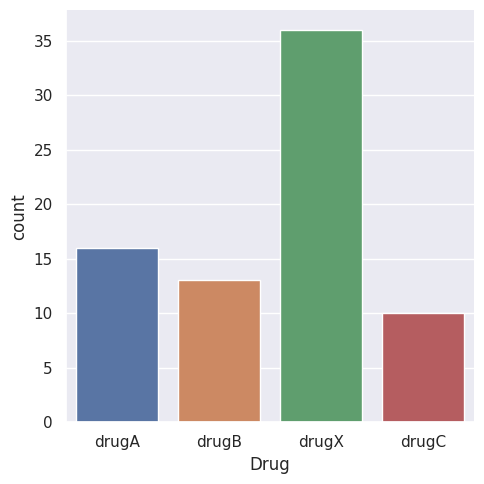

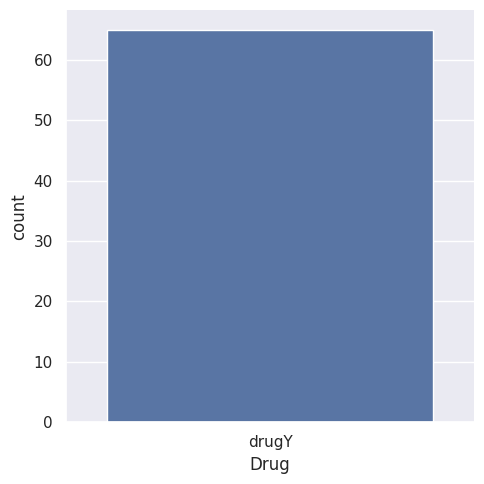

In [ ]:
sns.catplot(data = df_train[df_train['Na_to_K'] <= 14.7], x = 'Drug', kind = 'count')
sns.catplot(data = df_train[df_train['Na_to_K'] > 14.7], x = 'Drug', kind = 'count')

In [ ]:
c = df_train[df_train['Na_to_K'] >= 14.7]['Drug'].value_counts().tolist()

In [ ]:
#c = [65]
first_split_right_NA_K = calc_gini_entropy(c)

Entropy: [-0.0]
Total Entropy: 0.0
Gini: [1.0]
Total Gini: 0.0


In [ ]:
c = df_train[df_train['Na_to_K']< 14.7]['Drug'].value_counts().tolist()
df_train[df_train['Na_to_K']< 14.7]['Drug'].value_counts(), c

(drugX    36
 drugA    16
 drugB    13
 drugC    10
 Name: Drug, dtype: int64,
 [36, 16, 13, 10])

In [ ]:
# c =[36, 16, 13, 10]
first_split_left_NA_K = calc_gini_entropy(c)

Entropy: [0.5083, 0.4755, 0.4383, 0.3876]
Total Entropy: 1.8096
Gini: [0.2304, 0.0455, 0.03, 0.0178]
Total Gini: 0.6763


In [ ]:
first_split_left_NA_K

(0.6763, 1.8096)

### Split Option 2 - BP

In [ ]:
# Total number of BP categories

c = df_train['BP'].value_counts().tolist()
c

[57, 42, 41]

In [ ]:
# c = [57,42,41]

# Calculating Gini Entropy for the dataset containing BP as the root
first_split_BP = calc_gini_entropy(c)

Entropy: [0.5278, 0.5211, 0.5189]
Total Entropy: 1.5678
Gini: [0.1658, 0.09, 0.0858]
Total Gini: 0.6585


In [ ]:
# Subsetting - Splitting the data to 2 classes: BP: (0,1) and (2)

c1 = df_train[(df_train['BP'] == 1) | (df_train['BP'] == 0)]['Drug'].value_counts().tolist()
c1

[37, 36, 10]

In [ ]:
# Class 2: BP: (2)

c2 = df_train[df_train['BP'] == 2]['Drug'].value_counts().tolist()
c2

[28, 16, 13]

In [ ]:
#c1 = [37,36,10]

# Calculating Gini for the left and right sample split

first_split_left_BP = calc_gini_entropy(c1)

Entropy: [0.5196, 0.5227, 0.3678]
Total Entropy: 1.4101
Gini: [0.1987, 0.1881, 0.0145]
Total Gini: 0.5986


In [ ]:
#c2 = [28,16,13]
first_split_right_BP = calc_gini_entropy(c2)

Entropy: [0.5038, 0.5145, 0.4863]
Total Entropy: 1.5046
Gini: [0.2413, 0.0788, 0.052]
Total Gini: 0.6279


## INFORMATION GAIN

In [ ]:
# Information Gain - NA_to_K
#root_gini_entro[0]
infoGain_NA_K =  root_gini[0] - ((4/5)* first_split_left_NA_K[0] + (1/5)* first_split_right_NA_K[0])
print(f'{round(infoGain_NA_K,4)}')

#(f'Total Gini: {round(1 - sum(gini), 4)}')

0.153


In [ ]:
# Information Gain - BP
# root_gini_entro[0]

infoGain_BP =  first_split_BP[0] - ((4/5)* first_split_left_BP[0] + (1/5)* first_split_right_BP[0])

In [ ]:
infoGain_BP

0.05403999999999998

In [ ]:
infoGain_NA_K > infoGain_BP

True

**The gain for NA_to_K is higher than the feautre BP, concluding with the first split**

### Decision Tree - Gini

In [ ]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=10)

# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=10)

In [ ]:
y_pred_gini = clf_gini.predict(X_test)
y_pred_train_gini = clf_gini.predict(X_train)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Training-set accuracy score: 0.9286
Model accuracy score with criterion gini index: 0.9000


In [ ]:
# plt.figure(figsize=(12,8))
# tree.plot_tree(clf_gini.fit(X_train, y_train))
# plt.title('DT Gini')

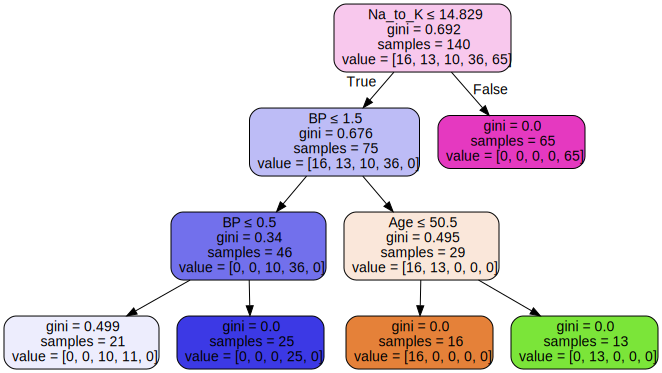

In [ ]:
dot_data = tree.export_graphviz(clf_gini,
                                out_file=None,
                                feature_names=X_train.columns,
                                #class_names=y_train['Drug'].unique(),
                                filled=True, rounded=True,
                                special_characters=True)

graph_gini = graphviz.Source(dot_data)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('Decision_Tree/Pydot_Gini.png')

graph_gini

### Decision Tree - Entropy

In [ ]:
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)

# fit the model
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)

In [ ]:
y_pred_entropy = clf_entropy.predict(X_test)
y_pred_train_entropy = clf_entropy.predict(X_train)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_entropy)))
print('Model accuracy score with criterion entropy index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_entropy)))

Training-set accuracy score: 0.9286
Model accuracy score with criterion entropy index: 0.9000


In [ ]:
# plt.figure(figsize=(12,8))
# tree.plot_tree(clf_entropy.fit(X_train, y_train))
# plt.title('DT Entropy')

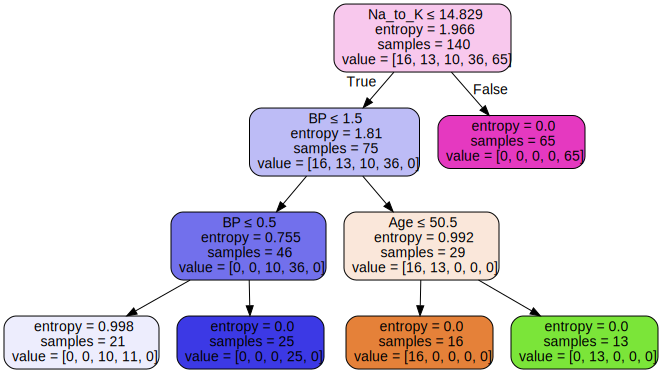

In [ ]:
dot_data = tree.export_graphviz(clf_entropy,
                                out_file=None,
                                feature_names=X_train.columns,
                                #class_names=y_train['Drug'].unique(),
                                filled=True, rounded=True,
                                special_characters=True)

graph_entropy = graphviz.Source(dot_data)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('Decision_Tree/Pydot_Gini.png')

graph_entropy

In [ ]:
y_pred_gini.shape, y_test.shape

((60,), (60, 1))

In [ ]:
clf_gini.classes_

array(['drugA', 'drugB', 'drugC', 'drugX', 'drugY'], dtype=object)

[Text(0.5, 1.0, 'Confusion Matrix of Gini DT')]

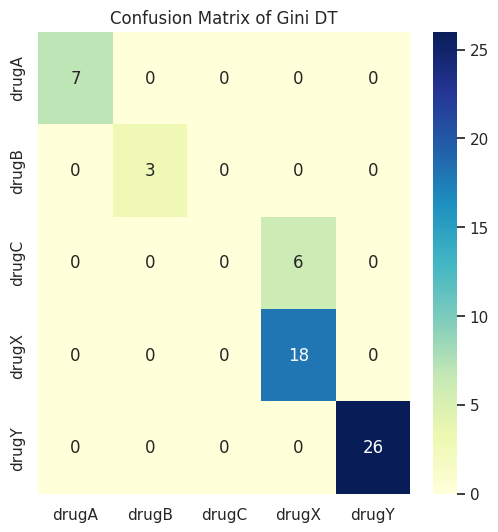

In [ ]:
classes = ['drugA', 'drugB', 'drugC', 'drugX', 'drugY']
cm = confusion_matrix(y_test, y_pred_gini)
sns.set(rc={'figure.figsize':(6,6)})
cm_matrix = pd.DataFrame(data=cm)


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=classes, yticklabels=classes).set(title='Confusion Matrix of Gini DT')

[Text(0.5, 1.0, 'Confusion Matrix of Entropy DT')]

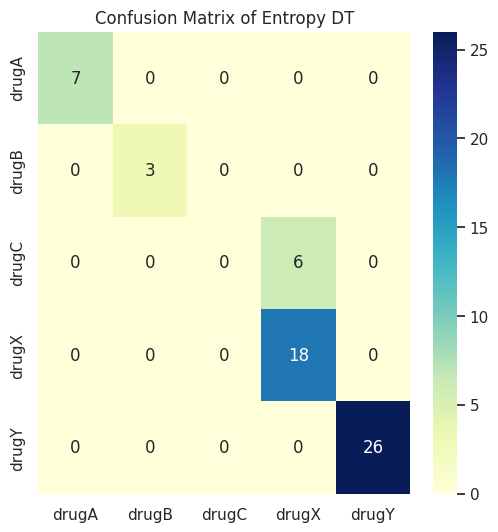

In [ ]:
cm = confusion_matrix(y_test, y_pred_entropy)
sns.set(rc={'figure.figsize':(6,6)})
cm_matrix = pd.DataFrame(data=cm)


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=classes, yticklabels=classes).set(title='Confusion Matrix of Entropy DT')

## INFO GAIN Comparision

In [ ]:
# Split option 1 using 'Na_to_K'
split1_left = df_train[df_train['Na_to_K'] < 14.7]
split1_right = df_train[df_train['Na_to_K'] >= 14.7]

# Calculate Gini impurity for each split
c_left = [
    len(split1_left[split1_left['Drug'] == 'drugA']),
     len(split1_left[split1_left['Drug'] == 'drugB']),
    len(split1_left[split1_left['Drug'] == 'drugC']),
    len(split1_left[split1_left['Drug'] == 'drugX']),
    len(split1_left[split1_left['Drug'] == 'drugY'])
]

c_right = [
    len(split1_right[split1_right['Drug'] == 'drugA']),
    len(split1_right[split1_right['Drug'] == 'drugB']),
        len(split1_left[split1_left['Drug'] == 'drugC']),
    len(split1_right[split1_right['Drug'] == 'drugX']),
    len(split1_right[split1_right['Drug'] == 'drugY'])
]

gini_split1_left = 1 - sum([(count / len(split1_left))**2 for count in c_left])
gini_split1_right = 1 - sum([(count / len(split1_right))**2 for count in c_right])

# Calculate weighted Gini impurity for split 1
total_samples = len(df_train)
weighted_gini_split1 = (len(split1_left) / total_samples) * gini_split1_left + (len(split1_right) / total_samples) * gini_split1_right

# Split option 2 using 'BP'
split2_left = df_train[(df_train['BP'] == 1) | (df_train['BP'] == 0)]
split2_right = df_train[df_train['BP'] == 2]

# Calculate Gini impurity for each split
c_left = [
    len(split2_left[split2_left['Drug'] == 'drugA']),
    len(split2_left[split2_left['Drug'] == 'drugB']),
    len(split1_left[split1_left['Drug'] == 'drugC']),
    len(split2_left[split2_left['Drug'] == 'drugX']),
    len(split2_left[split2_left['Drug'] == 'drugY'])
]

c_right = [
    len(split2_right[split2_right['Drug'] == 'drugA']),
    len(split2_right[split2_right['Drug'] == 'drugB']),
    len(split1_left[split1_left['Drug'] == 'drugC']),
    len(split2_right[split2_right['Drug'] == 'drugX']),
    len(split2_right[split2_right['Drug'] == 'drugY'])
]

gini_split2_left = 1 - sum([(count / len(split2_left))**2 for count in c_left])
gini_split2_right = 1 - sum([(count / len(split2_right))**2 for count in c_right])

# Calculate weighted Gini impurity for split 2
weighted_gini_split2 = (len(split2_left) / total_samples) * gini_split2_left + (len(split2_right) / total_samples) * gini_split2_right

# Root Gini impurity
root_gini = 1 - sum([(len(df_train[df_train['Drug'] == 'drug' + str(i)]) / total_samples) ** 2 for i in range(5)])

print(f'Weighted Gini for Split Option 1: {weighted_gini_split1:.4f}')
print(f'Weighted Gini for Split Option 2: {weighted_gini_split2:.4f}')
print(f'Root Gini Impurity: {root_gini:.4f}')

# Compare the Gini impurities
if weighted_gini_split1 < weighted_gini_split2:
    print("Split Option 1 is better.")
else:
    print("Split Option 2 is better.")

Weighted Gini for Split Option 1: 0.3513
Weighted Gini for Split Option 2: 0.5980
Root Gini Impurity: 1.0000
Split Option 1 is better.


### INFO GAIN - Test

In [ ]:
import math

def calculate_information_gain(initial_probabilities, subgroup1, subgroup2):
    # Calculate the total count
    total_count = sum(initial_probabilities)

    # Calculate the initial entropy
    initial_entropy = 0
    for p in initial_probabilities:
        probability = p / total_count
        if probability > 0:
            log_prob = math.log(probability, 2)
            initial_entropy += -probability * log_prob

    # Calculate the total count for each subgroup
    total_count_subgroup1 = sum(subgroup1)
    total_count_subgroup2 = sum(subgroup2)

    # Calculate the entropy of each subgroup
    entropy_subgroup1 = 0
    entropy_subgroup2 = 0

    for p in subgroup1:
        probability = p / total_count_subgroup1
        if probability > 0:
            log_prob = math.log(probability, 2)
            entropy_subgroup1 += -probability * log_prob

    for p in subgroup2:
        probability = p / total_count_subgroup2
        if probability > 0:
            log_prob = math.log(probability, 2)
            entropy_subgroup2 += -probability * log_prob

    # Calculate the weighted average of entropies for the subgroups
    weighted_entropy = (total_count_subgroup1 / total_count) * entropy_subgroup1 + (total_count_subgroup2 / total_count) * entropy_subgroup2

    # Calculate the information gain
    information_gain = initial_entropy - weighted_entropy

    return information_gain
